In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input/translator/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/translator/train.py
/kaggle/input/translator/prepare_data.py
/kaggle/input/translator/evaluate.py
/kaggle/input/translator/validation
/kaggle/input/translator/model.py
/kaggle/input/translator/utils.py
/kaggle/input/translator/requirements.txt
/kaggle/input/translator/test
/kaggle/input/translator/train


# Import libraries

In [2]:
os.chdir("/kaggle/input/translator/")
os.getcwd()

'/kaggle/input/translator'

In [3]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 62.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.7 MB/s eta 0:00:00


In [4]:
import prepare_data as pre
import contractions
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from model import Encoder, DecoderAttn
from train import train
from evaluate import evaluateRandom, translate_sentence, calcBLEU

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchmetrics.text import BLEUScore

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# I. Prepare Data
## 1. Download and save to local

In [6]:
# pre.download_data("data/multi30k")
# ds = pre.load_from_disk("data/multi30k")
# ds

## 2. Translate and save datasets

This cell take me 30+ mins to translate to Vietnamese :V

In [7]:
# for name_set in ds:
#     result = pre.translate_dataset(ds[name_set]['en'])
#     pre.save_data(src_data=ds[name_set]['en'],
#                   tgt_data=result,
#                   path_to_save=f"data/myData/{name_set}")

# II. Preprocess

In [8]:
root_path = ""
train_data, test_data, val_data = pre.get_dataset("train", root_path=root_path),\
                            pre.get_dataset("test", root_path=root_path),\
                            pre.get_dataset("validation", root_path)
print(train_data, val_data, test_data)

Dataset({
    features: ['en', 'vi'],
    num_rows: 29000
}) Dataset({
    features: ['en', 'vi'],
    num_rows: 1014
}) Dataset({
    features: ['en', 'vi'],
    num_rows: 1000
})


## 1. Lower & contractions & remove special character

In [9]:
lst_check = "‘’“”…—"
for char in lst_check:
    for x in train_data['vi']:
        a = x.count(char)
        if a > 0 and a % 2 == 0:
            print(x)
    for x in train_data['en']:
        a = x.count(char)
        if a > 0 and a % 2 == 0:
            print(x)

This cell doesn't print anything. So there is no need to remove these characters in the text :3

In [10]:
def update_contractions(text):
    # slang = False !
    return contractions.fix(text, slang=False)
def remove_char_quotes(text):
    rs = text
    cnt1, cnt2 = text.count('"'), text.count("'")
    if cnt1 > 0 and cnt1 % 2 == 0:
        rs = text.replace('"','')
    if cnt2 > 0 and cnt2 % 2 == 0:
        rs = text.replace("'", '')
    return rs
def processing(texts):
    texts['en'], texts['vi'] = [remove_char_quotes(update_contractions(t)).lower().strip() for t in [texts['en'], texts['vi']]]
    return texts
train_data = train_data.map(processing)
test_data = test_data.map(processing)
val_data = val_data.map(processing)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

In [11]:
train_data[0]

{'en': 'two young, white males are outside near many bushes.',
 'vi': 'hai thanh niên da trắng ở bên ngoài gần nhiều bụi cây.'}

## 2. Filter data & Tokenization

In [12]:
sos_token = 0
eos_token = 1
unk_token = 2
max_length = 25

In [13]:
en_nlp = spacy.blank("en")
vi_nlp = spacy.blank('vi')

In [14]:
def filter_data(texts):
    return len(en_nlp.tokenizer(texts['en'])) <= max_length and len(vi_nlp.tokenizer(texts['vi'])) <= max_length
train_data = train_data.filter(filter_data)
val_data = val_data.filter(filter_data)
test_data = test_data.filter(filter_data)

Filter:   0%|          | 0/29000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
train_data, test_data, val_data

(Dataset({
     features: ['en', 'vi'],
     num_rows: 28181
 }),
 Dataset({
     features: ['en', 'vi'],
     num_rows: 963
 }),
 Dataset({
     features: ['en', 'vi'],
     num_rows: 984
 }))

In [16]:
en_vocab = utils.Vocabulary('en', train_data['en'], en_nlp)
vi_vocab = utils.Vocabulary('vi', train_data['vi'], vi_nlp)

In [17]:
en_vocab.get_index("meomeo")

2

In [18]:
utils.indexesFromSentence(en_vocab, "today meomeo", en_nlp)

[8572, 2]

# Model

In [45]:
hidden_size = 256
batch_size = 128
num_layers = 1
dropout = 0.2
learning_rate = 0.001
num_epochs = 369

## DataLoader

In [27]:
train_loader = utils.get_dataloader(train_data, en_vocab, vi_vocab, \
                                    en_nlp, vi_nlp, device, batch_size,\
                                    max_length, 0, 1)

In [46]:
encoder = Encoder(en_vocab.n_words, hidden_size, num_layers, dropout).to(device)
decoder = DecoderAttn(hidden_size, vi_vocab.n_words, device, max_length, 0, 1,2, num_layers, dropout).to(device)

encoder_opt = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_opt = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss(ignore_index = 1) # ignore eos_token

## Training

In [47]:
his_loss = train(train_loader, encoder, decoder, encoder_opt, decoder_opt, criterion, num_epochs, 5)

(5 1%) Time: 1m 5s (- 79m 0s) Avg.Loss: 1.84486
(10 2%) Time: 2m 10s (- 78m 20s) Avg.Loss: 0.90190
(15 4%) Time: 3m 16s (- 77m 25s) Avg.Loss: 0.58869
(20 5%) Time: 4m 22s (- 76m 25s) Avg.Loss: 0.42129
(25 6%) Time: 5m 28s (- 75m 25s) Avg.Loss: 0.32055
(30 8%) Time: 6m 34s (- 74m 21s) Avg.Loss: 0.25263
(35 9%) Time: 7m 41s (- 73m 19s) Avg.Loss: 0.20581
(40 10%) Time: 8m 47s (- 72m 15s) Avg.Loss: 0.17025
(45 12%) Time: 9m 52s (- 71m 9s) Avg.Loss: 0.14353
(50 13%) Time: 10m 58s (- 70m 4s) Avg.Loss: 0.12224
(55 14%) Time: 12m 4s (- 68m 58s) Avg.Loss: 0.10724
(60 16%) Time: 13m 11s (- 67m 53s) Avg.Loss: 0.09399
(65 17%) Time: 14m 17s (- 66m 48s) Avg.Loss: 0.08383
(70 18%) Time: 15m 23s (- 65m 43s) Avg.Loss: 0.07433
(75 20%) Time: 16m 29s (- 64m 37s) Avg.Loss: 0.06847
(80 21%) Time: 17m 34s (- 63m 30s) Avg.Loss: 0.06251
(85 23%) Time: 18m 41s (- 62m 25s) Avg.Loss: 0.05677
(90 24%) Time: 19m 47s (- 61m 19s) Avg.Loss: 0.05306
(95 25%) Time: 20m 52s (- 60m 13s) Avg.Loss: 0.04935
(100 27%) Time:

## Save & Load model

In [48]:
root_path = "/kaggle/working/"
enc_path = os.path.join(root_path,'encoder.pth')
dec_path = os.path.join(root_path,'decoder.pth')

In [49]:
torch.save(encoder.state_dict(), enc_path)
torch.save(decoder.state_dict(), dec_path)

In [50]:
enc = Encoder(en_vocab.n_words, hidden_size, num_layers, dropout).to(device)
dec = DecoderAttn(hidden_size, vi_vocab.n_words, device, max_length, 0, 1, 2, num_layers, dropout).to(device)

enc.load_state_dict(torch.load(enc_path, weights_only=True))
dec.load_state_dict(torch.load(dec_path, weights_only=True))

enc.eval()
dec.eval()

DecoderAttn(
  (embedding): Embedding(6067, 256)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=256, out_features=256, bias=True)
    (Ua): Linear(in_features=256, out_features=256, bias=True)
    (Va): Linear(in_features=256, out_features=1, bias=True)
  )
  (lstm): LSTM(512, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=6067, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Visualization Loss 

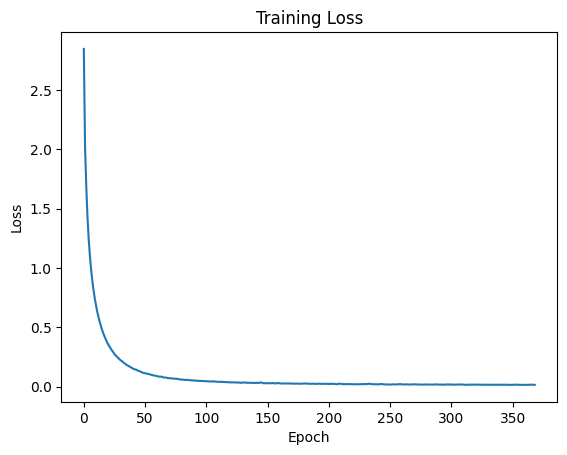

In [51]:
import matplotlib.pyplot as plt

plt.plot(his_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


# Evaluate

In [57]:
evaluateRandom(enc, dec, train_data, en_vocab, vi_vocab, en_nlp, vi_nlp, device, 10)

English:	 little girl with brown snow jacket and purple snow pants is playing in the snow with a red shovel.
Vi_true:	 cô bé mặc áo khoác tuyết nâu và quần tuyết tím đang chơi đùa trong tuyết với một chiếc xẻng đỏ.
Vi_pred:	 cô bé mặc áo khoác tuyết nâu và quần tuyết tím đang chơi đùa trong tuyết với một chiếc xẻng đỏ . . .
------------
English:	 there is an older man, ironing a shirt for his work.
Vi_true:	 có một người đàn ông lớn tuổi đang là áo sơ mi để làm việc.
Vi_pred:	 có một người đàn ông lớn tuổi đang là áo sơ mi để làm việc .
------------
English:	 a woman is covered up completely and fixing a machine.
Vi_true:	 một người phụ nữ được che phủ hoàn toàn và đang sửa một chiếc máy.
Vi_pred:	 một người phụ nữ được che phủ hoàn toàn và đang sửa một chiếc máy . .
------------
English:	 two people wearing backpacks and a woman in red shorts are standing on some large rock formations.
Vi_true:	 hai người đeo ba lô và một người phụ nữ mặc quần short đỏ đang đứng trên một số khối đá lớ

In [64]:
evaluateRandom(enc, dec, val_data, en_vocab, vi_vocab, en_nlp, vi_nlp, device, 10)

English:	 a man adjusts the engine of a boat near the water.
Vi_true:	 một người đàn ông đang điều chỉnh động cơ của một chiếc thuyền gần mặt nước.
Vi_pred:	 một người đàn ông đang điều chỉnh động cơ của một chiếc thuyền gần mặt nước . xuống nước . xuống nước . xuống nước . xuống nước . xuống nước . a .
------------
English:	 two men in black clothes with blue and red bowties are performing in front of a crowd.
Vi_true:	 hai người đàn ông mặc đồ đen thắt nơ xanh và đỏ đang biểu diễn trước đám đông.
Vi_pred:	 hai người đàn ông mặc quần áo đen với chiếc nơ xanh và đỏ đang biểu diễn trước đám đông .
------------
English:	 a child in an orange shirt jumps off bales of hay while other children watch.
Vi_true:	 một đứa trẻ mặc áo sơ mi màu cam nhảy khỏi những kiện cỏ khô trong khi những đứa trẻ khác đang xem.
Vi_pred:	 một đứa trẻ mặc áo sơ mi màu cam nhảy khỏi những kiện rơm trong khi những đứa trẻ khác đang xem .
------------
English:	 a young girl running by herself in a park.
Vi_true:	 m

In [60]:
inp_texts = ["people wearing the dirty jeans and riding a bicycle together",
             "a boy play video game while his older brother do homework"]
translate_sentence(enc, dec, inp_texts, en_vocab, vi_vocab, en_nlp, device)

['người mặc quần jean bẩn và đạp xe cùng nhau .',
 'một cậu bé chơi trò quay trong khi chị học sinh tiểu học của cậu bé của mình .']

# BLEU Score

In [63]:
calcBLEU(enc, dec, test_data,  en_vocab, vi_vocab, en_nlp, vi_nlp, device)

Average BLEU score: 0.5019


0.5018874600571491

In [65]:
evaluateRandom(enc, dec, test_data, en_vocab, vi_vocab, en_nlp, vi_nlp, device, 10)

English:	 a smiling young boy plays in the leaves among the ducks.
Vi_true:	 một cậu bé tươi cười đang chơi đùa giữa đám lá cây giữa đàn vịt.
Vi_pred:	 một cậu bé mỉm cười chơi đùa giữa những cầu thủ trong những con vịt .
------------
English:	 an elderly person is crossing a street with an umbrella in their hands.
Vi_true:	 một người lớn tuổi đang băng qua đường với chiếc ô trên tay.
Vi_pred:	 một người già đang băng qua đường với chiếc ô trên tay .
------------
English:	 a brown dog with a purple frisbee in its mouth.
Vi_true:	 một chú chó nâu đang ngậm một chiếc đĩa frisbee màu tím trong miệng.
Vi_pred:	 một chú chó nâu ngậm một chiếc đĩa frisbee màu hồng há miệng . miệng .
------------
English:	 a woman and a child are walking down a street.
Vi_true:	 một người phụ nữ và một đứa trẻ đang đi bộ trên phố.
Vi_pred:	 một người phụ nữ và một đứa trẻ đang đi bộ trên phố .
------------
English:	 multiple people in a park eating at a picnic table
Vi_true:	 nhiều người trong công viên đang 